# TF network pipeline
## Alexandre Grimaldi 10/04/2021
This script requires:
- pyscenic output file to extract regulon AUC matrix & regulons
- pyscenic adj matrix

In [110]:
# import dependencies
import os
import numpy as np
import pandas as pd
import scanpy as sc
import loompy as lp
import json
import base64
import zlib

In [111]:
# set a working directory
wdir = "PATH_TO_WORKING_DIRECTORY"
os.chdir( wdir )

# loom output, generated from a combination of Scanpy and pySCENIC results:
pyscenic_file = "PATH_TO_PYSCENIC_FILE.LOOM"

ident = "METADATA_IDENT" #ex: CellType

cluster = "NAME_OF_SELECTED_CLUSTER" # ex: Macrophages

### Generating top regulons for each clusters in given ident

In [112]:
# Extract AUC matrix and regulons from pyscenic file
lf = lp.connect( pyscenic_file, mode='r', validate=False )
meta = json.loads(zlib.decompress(base64.b64decode( lf.attrs.MetaData )))
exprMat = pd.DataFrame( lf[:,:], index=lf.ra.Gene, columns=lf.ca.CellID).T
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)

In [113]:
# create a dictionary of regulons:
regulons = {}
for i,r in pd.DataFrame(lf.ra.Regulons,index=lf.ra.Gene).iteritems():
    regulons[i] =  list(r[r==1].index.values)

In [114]:
# close loom file
lf.close()

In [115]:
# Add ident metadata to AUC matrix
auc_mtx.to_csv("auc_mtx.csv")
auc = sc.read("auc_mtx.csv")
adata = sc.read(pyscenic_file, validate = False)
auc.obs = adata.obs

... storing 'Clusterings' as categorical
... storing 'cellType' as categorical
... storing 'seurat_clusters' as categorical


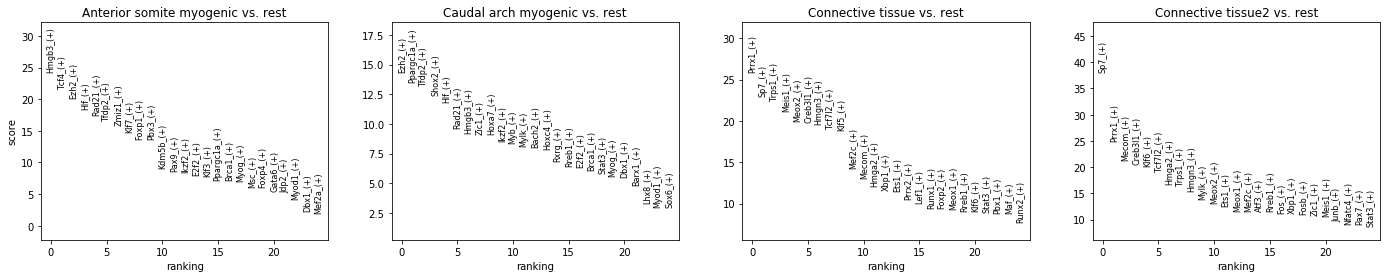

In [116]:
# Finding the top regulons in each cluster
sc.tl.rank_genes_groups(auc, ident, method='t-test', n_genes=35)
sc.pl.rank_genes_groups(auc, n_genes=25, sharey=False)

### Make dictionary of TF network

In [118]:
# Making an array of TFs that regulate TFs
match = []

l = list(regulons.keys())
for regulon in l:
    for target in regulons[regulon]:
        if target+"_(+)" in l:
            match.append(target)

# Remove duplicated regulons
match = list( dict.fromkeys(match))

# Making dictionary of TF regulating TF
d = {}
for x in match:
    d[x]=[y for y in regulons[x+"_(+)"] if y in match]

### Make edges

b = np.empty(0)
c = np.empty(0)
for i in list(d.keys()):
    b = np.append(b, np.repeat(str(list(d.keys()).index(i)+1), len(d[i])))
    for j in d[i]:
        c = np.append(c, str(list(d.keys()).index(j)+1))

clustdic = {}

for i in list(d.keys()):
    for x in auc.obs[ident].cat.categories:
        if i+"_(+)" in auc.uns['rank_genes_groups']['names'][x]:
            clustdic[i] = x
        elif i not in clustdic.keys():
            clustdic[i] = "Other"

sourcedict = {"Id": list(range(1,len(d.keys())+1)), "Label" : list(d.keys()), "Cluster" : list(clustdic.values())}

Nodedf = pd.DataFrame.from_dict(sourcedict, orient ='columns')

Nodedf.to_csv(cluster + "TFnetwork_Nodes.csv", index=False)

data = {"Source" : b, "Target":c}

Edgedf = pd.DataFrame(data)

### Adding weight to the edges

adj = pd.read_csv("adj.tsv", sep="\\t")

weight=[]
for i in range(0,len(Edgedf.index)):
    x = Nodedf["Label"][Nodedf["Id"]==int(Edgedf.loc[i,"Source"])].to_string(index=False).strip()
    y = Nodedf["Label"][Nodedf["Id"]==int(Edgedf.loc[i,"Target"])].to_string(index=False).strip()
    if x == y:
        weight = np.append(weight, 200)
    else:
        weight = np.append(weight, adj["importance"][(adj["TF"]==x) & (adj["target"]==y)])

data = {"Source" : b, "Target":c, "Weight":weight}

Edgedf = pd.DataFrame(data)

Edgedf.to_csv(cluster + "TFnetwork_Edges.csv", index=False)